In [ ]:
!pip install tensorflow google-cloud-storage

In [ ]:
from google.cloud import storage
from IPython.display import Image, display
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from dotenv import load_dotenv
import tensorflow as tf
import pandas as pd
from io import StringIO

In [ ]:
# Load CSV data

# Assuming gcsfs is installed and configured
csv_path = 'gs://storage_for_all/DataSets/FacialEmotionRecognitionImageDataset_v1/data.csv'

# Use pandas to directly read from GCS
df = pd.read_csv(csv_path)

# Drop the first column if it is unnamed or not required
if 'Unnamed: 0' in df.columns or df.columns[0] == 'path':  # Check if the first column is 'path' or an unnamed index
    df.drop(df.columns[0], axis=1, inplace=True)

# Show the first few rows to verify
print(df.head())

# Create a dictionary mapping filenames to emotions
emotion_dict = pd.Series(df.label.values, index=df.path.apply(lambda x: x.split('/')[-1])).to_dict()
# print("emotion_dict is", emotion_dict)

In [ ]:
# Define global variables

load_dotenv()  # Load the environment variables from the .env file

GOOGLE_KEY_PATH = os.getenv('GOOGLE_APPLICATION_CREDENTIALS')
GOOGLE_BUCKET_NAME = os.getenv('GOOGLE_STORAGE_BUCKET')

# Set the GOOGLE_APPLICATION_CREDENTIALS environment variable
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = key_path

# Initialize the Google Cloud Storage client
client = storage.Client()

In [ ]:
def match_image_to_category_label(blob, emotion_dict):
    """Reads an image and its label from Google Cloud Storage."""
    image_data = blob.download_as_bytes()
    image_array = np.frombuffer(image_data, np.uint8)
    img = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Extract the filename from the blob and get the corresponding emotion
    filename = blob.name.split('/')[-1]  # Extract filename from path
    emotion = emotion_dict.get(filename, "Unknown")  # Fetch emotion label using filename
    
    return img, emotion

In [ ]:
bucket = client.bucket(bucket_name)
# Example: List files in the bucket
blobs = bucket.list_blobs()
# for blob in blobs:
#     print(blob.name)
# Define the path to the image file
blob_path = 'DataSets/FacialEmotionRecognitionImageDataset_v1/'

# Get the blobs in the directory
blobs = list(bucket.list_blobs(prefix=blob_path))
blobs = [blob for blob in blobs if 'Ahegao' not in blob.name]

In [ ]:
# Function to read image from GCS
def read_image_from_gcs(blob):
    """Reads an image from Google Cloud Storage into a numpy array."""
    image_data = blob.download_as_bytes()
    image_array = np.frombuffer(image_data, np.uint8)
    img = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [ ]:
# Print the file count and show random sample of images from the dataset
print(f"File count: {len(blobs)}")

# Display a random set of images
num_images = 3
num_samples = 3
plt.figure(figsize=(13, 13))

for i in range(num_images):
    for j in range(num_samples):
        random_blob = np.random.choice(blobs)  # Make sure 'blobs' contains the list of all blob objects you want to choose from
        img, emotion_label = match_image_to_category_label(random_blob, emotion_dict)
        
        plt.subplot(num_images, num_samples, i * num_samples + j + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(emotion_label)  # Display the emotion label as the title

plt.show()

In [ ]:
# This code streams from google storage bucket
# # Using glob to list all JPEG files in the specific GCS bucket directory
# filenames = tf.io.gfile.glob('gs://storage_for_all/DataSets/FacialEmotionRecognitionImageDataset_V1/*.jpg')

# # Calculate the total number of image files
# total_images = len(filenames)

# # Print the total number of image files
# print("Total number of image files:", total_images)

In [54]:
import pandas as pd

# Load CSV data
csv_path = 'gs://storage_for_all/DataSets/FacialEmotionRecognitionImageDataset_v1/data.csv'
df = pd.read_csv(csv_path)

# Create a dictionary mapping filenames to emotions
emotion_dict = pd.Series(df.label.values, index=df.path.apply(lambda x: x.split('/')[-1])).to_dict()

import tensorflow as tf

def load_and_process_image(file_path, label):
    """Load and process images using TensorFlow operations."""
    image_data = tf.io.read_file(f'gs://storage_for_all/DataSets/FacialEmotionRecognitionImageDataset_v1/{file_path}')
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.image.resize(image, [224, 224])  # Resize as needed
    return image, label

def fetch_label(file_path):
    """Fetch the label for a given file path from the emotion dictionary."""
    # We assume file_path is a tensor of type string
    return tf.py_function(func=lambda x: emotion_dict.get(x.numpy().decode('utf-8'), "Unknown"), 
                          inp=[file_path], Tout=tf.string)

# Prepare file paths and labels as tensors
file_paths = tf.data.Dataset.from_tensor_slices(df['path'].apply(lambda x: x.split('/')[-1]))
labels = file_paths.map(fetch_label)

# Combine file paths and labels into a single dataset
image_label_ds = tf.data.Dataset.zip((file_paths, labels))

print(image_label_ds.take(5))



# Map the dataset to load and process images
AUTOTUNE = tf.data.experimental.AUTOTUNE
dataset = image_label_ds.map(lambda fp, lbl: load_and_process_image(fp, lbl), num_parallel_calls=AUTOTUNE)

batch_size = 32
dataset = dataset.shuffle(1000).batch(batch_size).prefetch(AUTOTUNE)

# model = create_model()  # Assume this function creates your TensorFlow model
# model.fit(dataset, epochs=10)

<TakeDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=<unknown>, dtype=tf.string, name=None))>


In [55]:
import pandas as pd
import tensorflow as tf

# Load CSV data
csv_path = 'gs://storage_for_all/DataSets/FacialEmotionRecognitionImageDataset_v1/data.csv'
df = pd.read_csv(csv_path)

# Create a dictionary mapping filenames to emotions
emotion_dict = pd.Series(df.label.values, index=df.path.apply(lambda x: x.split('/')[-1])).to_dict()

def load_and_process_image(file_name):
    """Load and process images using TensorFlow operations."""
    file_path = f'gs://storage_for_all/DataSets/FacialEmotionRecognitionImageDataset_v1/{file_name}'
    image_data = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.image.resize(image, [224, 224])  # Resize as needed
    return image

def fetch_label(file_name):
    """Fetch the label for a given file path from the emotion dictionary."""
    label = emotion_dict.get(file_name, "Unknown")
    return label

# Prepare file paths and labels as tensors
file_names = df['path'].apply(lambda x: x.split('/')[-1]).values
labels = [fetch_label(name) for name in file_names]

# Convert lists to TensorFlow datasets
file_ds = tf.data.Dataset.from_tensor_slices(file_names)
label_ds = tf.data.Dataset.from_tensor_slices(labels)
image_label_ds = tf.data.Dataset.zip((file_ds.map(load_and_process_image), label_ds))

# To view the first 5 items
for image, label in image_label_ds.take(5):
    print("Image shape:", image.numpy().shape, "Label:", label.numpy())


2024-08-02 20:18:52.502909: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at whole_file_read_ops.cc:114 : NOT_FOUND: Error executing an HTTP request: HTTP response code 404 with body '<?xml version='1.0' encoding='UTF-8'?><Error><Code>NoSuchKey</Code><Message>The specified key does not exist.</Message><Details>No such object: storage_for_all/DataSets/FacialEmotionRecognitionImageDataset_v1/Tensor("args_0:0", shape=(), dtype=string)</Details></Error>'
	 when reading gs://storage_for_all/DataSets/FacialEmotionRecognitionImageDataset_v1/Tensor("args_0:0", shape=(), dtype=string)
2024-08-02 20:18:52.608675: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at whole_file_read_ops.cc:114 : NOT_FOUND: Error executing an HTTP request: HTTP response code 404 with body '<?xml version='1.0' encoding='UTF-8'?><Error><Code>NoSuchKey</Code><Message>The specified key does not exist.</Message><Details>No such object: storage_for_all/DataSets/FacialEmotionRecognition

NotFoundError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Error executing an HTTP request: HTTP response code 404 with body '<?xml version='1.0' encoding='UTF-8'?><Error><Code>NoSuchKey</Code><Message>The specified key does not exist.</Message><Details>No such object: storage_for_all/DataSets/FacialEmotionRecognitionImageDataset_v1/Tensor("args_0:0", shape=(), dtype=string)</Details></Error>'
	 when reading gs://storage_for_all/DataSets/FacialEmotionRecognitionImageDataset_v1/Tensor("args_0:0", shape=(), dtype=string)
	 [[{{node ReadFile}}]] [Op:IteratorGetNext]

                                                path     label
0  Surprise/1bd930d6a1c717c11be33db74823f661cb53f...  Surprise
1       Surprise/cropped_emotions.100096~12fffff.png  Surprise
2  Surprise/0df0e470e33093f5b72a8197fa209d684032c...  Surprise
3       Surprise/cropped_emotions.260779~12fffff.png  Surprise
4       Surprise/cropped_emotions.263616~12fffff.png  Surprise
Image shape: (224, 224, 3) Label: b'Surprise'


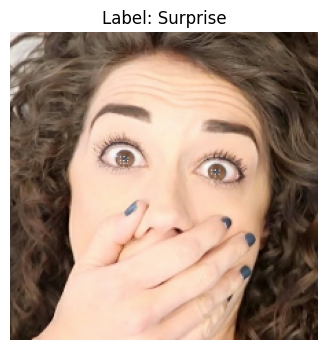

Image shape: (224, 224, 3) Label: b'Surprise'


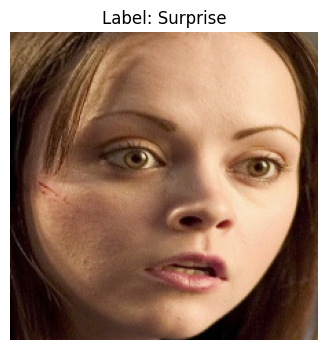

Image shape: (224, 224, 3) Label: b'Surprise'


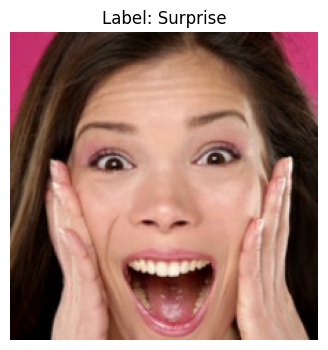

Image shape: (224, 224, 3) Label: b'Surprise'


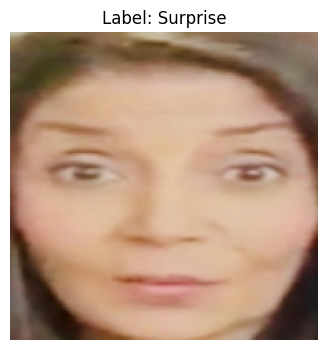

Image shape: (224, 224, 3) Label: b'Surprise'


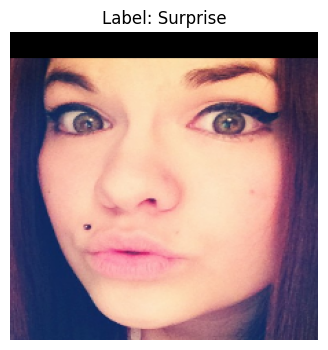

In [71]:
import pandas as pd
import tensorflow as tf

# Load CSV data
csv_path = 'gs://storage_for_all/DataSets/FacialEmotionRecognitionImageDataset_v1/data.csv'
df = pd.read_csv(csv_path)
df = df.drop(df.columns[0], axis=1)
#print(df.head())


# Adjust this part to ensure correct path handling:
# Make sure that the path column has correct and complete paths
#df['path'] = df['path'].apply(lambda x: f"gs://storage_for_all/DataSets/FacialEmotionRecognitionImageDataset_v1/{x.split('/')[-1]}")
df['path'] = df['path'].apply(lambda x: f"gs://storage_for_all/DataSets/FacialEmotionRecognitionImageDataset_v1/dataset/{x.split('/')[-2]}/{x.split('/')[-1]}")


def load_image(file_path):
    """Load and preprocess images from file paths."""
    image_data = tf.io.read_file(file_path)  # Ensure file_path is a proper string path
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.image.resize(image, [224, 224])  # Resize as needed
    return image

def prepare_dataset(paths, labels):
    """Prepare TensorFlow dataset from paths and labels."""
    path_ds = tf.data.Dataset.from_tensor_slices(paths)
    image_ds = path_ds.map(load_image)  # Load and process images
    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    return tf.data.Dataset.zip((image_ds, label_ds))

def display_image(image, label):
    """Display a single image and its label."""
    plt.figure(figsize=(4, 4))
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(f"Label: {label.numpy().decode('utf-8')}")
    plt.axis('off')
    plt.show()

# Preparing the dataset
paths = df['path'].tolist()  # Ensure this is a list of string paths
labels = df['label'].tolist()  # Corresponding labels
dataset = prepare_dataset(paths, labels)

# Example: Iterate through the dataset
for image, label in dataset.take(5):
    print("Image shape:", image.numpy().shape, "Label:", label.numpy())
    display_image(image, label)